In [99]:
import numpy as np
from collections import defaultdict
import os 
import subprocess
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.processors import BertProcessing
from transformers import BertTokenizerFast
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


In [100]:
genome_sequences_dir = "genome_sequences"
tokenizers_dir = "tokenizers"
subsampled_genomes_dir = "subsampled_genomes"
os.makedirs(subsampled_genomes_dir, exist_ok=True)
os.makedirs(tokenizers_dir, exist_ok=True)

organisms = [
    "Nanobdella aerobiophila",
    "Candidatus Karelsulcia muelleri",
    "Malassezia restricta",
    "Caenorhabditis elegans",
    "Ostreococcus lucimarinus CCE9901",
    "Theileria orientalis strain Shintoku",
    "Rice yellow mottle virus satellite"
]

def load_genome_sequence(filename):
    with open(os.path.join(genome_sequences_dir, filename), 'r') as f:
        return f.read().upper()

genomes = {org: load_genome_sequence(f"{org.replace(' ', '_')}_cleaned.txt") for org in organisms}

In [101]:
"""
This code subsamples the genome sequences, saving either the first 10^6 bases or the entire genome length, whichever one is smaller.
"""

def subsample_genome(genome, size=10**6):
    return genome[:min(size, len(genome))]

def save_subsampled_genome(org, subsample):
    subsample_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    with open(subsample_path, 'w') as f:
        f.write(subsample)
    return subsample_path

subsampled_genomes = {}
for org, genome in genomes.items():
    subsample = subsample_genome(genome)
    subsample_path = save_subsampled_genome(org, subsample)
    subsampled_genomes[org] = subsample_path

In [102]:
"""
This processes the genome files into chunks for the tokenizer. It splits the genome sequence into chunks of length 512.
"""
#TODO: need to find optimal chunking number. McCullen used 4192 for sentencepiece(a value specified by that model). I used 512 because it seems to be the standard NLP val but idk if that's great for genomic sequences

L = 512
for org, subsample_path in subsampled_genomes.items():
    with open(subsample_path, 'r') as f:
        genome = f.read()
    chunked_genome = '\n'.join([genome[i:i+L] for i in range(0, len(genome), L)])
    with open(os.path.join(genome_sequences_dir, f"{org.replace(' ', '_')}_processed.txt"), 'w') as f:
        f.write(chunked_genome)

In [103]:

"""
Explanation:
This generates k-mers (subsequences of length k) from a given genome sequence and calculates the frequency of each k-mer. This is useful for creating a vocabulary of k-mers which will be used in further analysis.
"""

def generate_kmers(sequence, k):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return kmers

def calculate_kmer_frequencies(genome_sequence, k):
    kmer_freqs = defaultdict(int)
    for i in range(len(genome_sequence) - k + 1):
        kmer = genome_sequence[i:i+k]
        kmer_freqs[kmer] += 1
    return kmer_freqs

def process_organism_kmers(org):
    genome_sequence = load_genome_sequence(f"{org.replace(' ', '_')}_processed.txt")
    k_values = [3, 4, 5, 6, 7]  
    kmer_freqs_all = {}
    for k in k_values:
        kmer_freqs_all[k] = calculate_kmer_frequencies(genome_sequence, k)
        print(f"k-mer frequencies for k={k}:", kmer_freqs_all[k])
    return kmer_freqs_all, genome_sequence

# Example for one organism
org = "Nanobdella aerobiophila"
kmer_freqs_all, genome_sequence = process_organism_kmers(org)

k-mer frequencies for k=3: defaultdict(<class 'int'>, {'AAT': 34817, 'ATA': 46557, 'TAT': 47254, 'ATT': 35666, 'TTA': 31019, 'TAA': 30209, 'TTT': 36084, 'TTC': 13634, 'TCA': 9088, 'CAT': 10829, 'AAA': 35315, 'TAC': 9576, 'ACT': 7215, 'CTT': 12248, 'TAG': 11958, 'AGT': 7284, 'GTA': 9505, 'GTT': 6845, 'TTG': 10082, 'TGA': 8973, 'GAA': 13475, 'AGG': 5867, 'GGA': 7117, 'GAC': 2324, 'ACA': 7660, 'CAA': 10138, 'CAC': 2072, 'GGT': 4953, 'GTC': 2277, 'TCT': 16642, 'CTA': 11866, 'ATG': 10577, 'TGG': 6654, 'TGT': 7428, 'AAC': 6849, 'ACC': 4963, 'CCT': 5808, 'GAT': 14048, 'ATC': 14133, 'AAG': 12129, 'AGA': 16372, 'GTG': 2023, 'GAG': 4351, 'GGC': 1744, 'GCA': 4581, 'CAG': 4941, 'ACG': 976, 'CGA': 1739, 'AGC': 3860, 'GCT': 3859, 'CTC': 4488, 'TCC': 7065, 'CCA': 6648, 'AA\n': 173, 'A\nA': 142, '\nAT': 206, 'TGC': 4559, 'CTG': 4914, 'CGG': 1297, 'CCG': 1313, 'GCG': 830, 'AG\n': 65, 'G\nA': 62, 'CGT': 972, 'GCC': 1726, 'TCG': 1721, 'GGG': 2143, 'A\nG': 67, '\nGA': 68, 'TG\n': 45, 'G\nG': 32, '\nGG': 3

In [104]:
""""
This creates a vocab of k-mers based on their frequencies and calculates the compression factor of the genome sequence.
It also performs a heuristic search to find the optimal vocabulary size that minimizes the compression factor."""

def create_vocabulary(kmer_freqs, vocab_size):
    sorted_kmers = sorted(kmer_freqs.items(), key=lambda x: x[1], reverse=True)
    vocab = [kmer for kmer, freq in sorted_kmers[:vocab_size]]
    return vocab

def calculate_compression(genome_sequence, vocab, k):
    total_length = len(genome_sequence)
    encoded_length = sum([genome_sequence.count(kmer) for kmer in vocab])
    compression_factor = total_length / encoded_length if encoded_length != 0 else float('inf')
    return compression_factor

def heuristic_search_optimal_vocab_size(kmer_freqs, genome_sequence, k, initial_vocab_size=50, step_size=500, max_vocab_size=100000):
    vocab_size = initial_vocab_size
    best_vocab_size = vocab_size
    best_compression_factor = float('inf')
    compression_factors = []
    last_compression_factor = None
    no_improvement_count = 0

    while vocab_size <= max_vocab_size:
        vocab = create_vocabulary(kmer_freqs, vocab_size)
        compression = calculate_compression(genome_sequence, vocab, k)
        compression_factors.append(compression)

        print(f"vocab size: {vocab_size}, compression factor: {compression}")

        if compression < best_compression_factor:
            best_compression_factor = compression
            best_vocab_size = vocab_size
            no_improvement_count = 0
        elif compression == last_compression_factor:
            no_improvement_count += 1
            if no_improvement_count >= 3:  
                break
        else:
            no_improvement_count = 0

        last_compression_factor = compression
        vocab_size += step_size

    return best_vocab_size, best_compression_factor, compression_factors

# Example for one organism w k=6
optimal_vocab_size, optimal_compression_factor, compression_factors = heuristic_search_optimal_vocab_size(kmer_freqs_all[6], genome_sequence, 6)
print(f"optimal vocab size for {org}: {optimal_vocab_size}, compression factor: {optimal_compression_factor}")

vocab size: 50, compression factor: 5.666542672359133
vocab size: 550, compression factor: 1.6568170638559787
vocab size: 1050, compression factor: 1.3097317291928428
vocab size: 1550, compression factor: 1.177505946671445
vocab size: 2050, compression factor: 1.103859829414545
vocab size: 2550, compression factor: 1.0626322806895163
vocab size: 3050, compression factor: 1.0393234993572718
vocab size: 3550, compression factor: 1.025589746963857
vocab size: 4050, compression factor: 1.0179977126957536
vocab size: 4550, compression factor: 1.014156217705561
vocab size: 5050, compression factor: 1.0119956758193145
vocab size: 5550, compression factor: 1.0104700281311338
vocab size: 6050, compression factor: 1.0095933411457785
vocab size: 6550, compression factor: 1.0088335606067447
vocab size: 7050, compression factor: 1.0080749227701091
vocab size: 7550, compression factor: 1.0080446009883925
vocab size: 8050, compression factor: 1.0080446009883925
vocab size: 8550, compression factor: 1

In [105]:
"""
This splits the genome sequence into smaller chunks for training the WordPiece tokenizer.
Note: the wordpiece tokenizer uses built in special tokens. UNK represents any token not found in the vocab and is used when the tokenizer encounters a word/subword that's not in the vocab. 
PAD makes sure that sequences in a batch have the same length by padding shorter sequences to match the longest sequence. 
CLS is a fixed token at the beginning of every input sequence. Its helpful for classification tasks. The hidden state corresponding to this token is typically used for sequence-level tasks, like classification or regression.
However, I'm not sure that we need it since we don't have delimiters in our genomic sequences. 
SEP seperates distinct sequences/segments in the input. Again, I'm not sure if we need this because it is typically used to distinguish between multiple segments, esp in tasks involving 
sentence pairs, like question answering and classification. 
MASK is used in masked language modeling tasks where certain tokens in the input are replaced with MASK. It helps the model learn to predict masked tokens based on the surrounding context. 

I included N like we talked about, but I'm not sure if we need it since UNK seems like it would take care of it?
Feel free to adjust/add/delete any special tokens. You have to include UNK though in order for wordpiece to run.  """

def split_sequence_into_chunks(sequence, chunk_size):
    chunks = [sequence[i:i+chunk_size] for i in range(0, len(sequence), chunk_size)]
    return chunks

def train_and_save_wordpiece_tokenizer(chunks, vocab_size, save_path):
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.WordPieceTrainer(vocab_size=vocab_size, special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]", "[N]"])
    tokenizer.train_from_iterator(chunks, trainer=trainer)
    tokenizer.post_processor = BertProcessing(
        ("[SEP]", tokenizer.token_to_id("[SEP]")),
        ("[CLS]", tokenizer.token_to_id("[CLS]")),
    )
    tokenizer.save(save_path)
    
    tokenizer.model.save(os.path.dirname(save_path))

chunk_size = 50
chunks = split_sequence_into_chunks(genome_sequence, chunk_size)

tokenizer_save_path = "bert_wordpiece_tokenizer.json"
train_and_save_wordpiece_tokenizer(chunks, optimal_vocab_size, tokenizer_save_path)

In [106]:
#TODO: why the heck is the tokenized sequence just printing Wordpiece special tokens????! (ahhhhhh)

def load_bert_tokenizer_from_saved(vocab_file, save_path):
    tokenizer = BertTokenizerFast(vocab_file=vocab_file, do_lower_case=False)
    return tokenizer

def tokenize_sequence(tokenizer, sequence):
    encoding = tokenizer(sequence)
    return encoding.tokens()

vocab_file = "vocab.txt"
tokenizer = load_bert_tokenizer_from_saved(vocab_file, tokenizer_save_path)
tokens = tokenize_sequence(tokenizer, genome_sequence)

print('raw sequence:')
print(genome_sequence[:100])
print('\ntokenized sequence:')
print(' '.join(tokens[:100]))
print()
print('# tokens in genome:', len(tokens))

raw sequence:
AATATTATAATATTTCATTAAATATAAAAAATATATATTATTACTTATTAGTAGTTTTGAATAATAGGACAAATATAATAAAAATATATTACACTTTGAA

tokenized sequence:
[CLS] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]

# tokens in genome: 1309


In [107]:
"""this plots all the compression factors vs vocab sizes. I commented it out because it takes forever to run. """

#def plot_compression_factors(org, compression_factors, vocab_sizes):
#    plt.figure(figsize=(10, 6))
#    plt.plot(vocab_sizes, compression_factors, marker='o')
#    plt.xlabel('vocab size')
#    plt.ylabel('compression factor')
#    plt.title(f'compression factor vs vocab size for {org}')
#    plt.grid(True)
#    plt.show()

#org = "Nanobdella aerobiophila"

# adjust range and/or k val as needed

#vocab_sizes_checked = list(range(1000, 80000, 500))  
#k = 6  
#compression_factors = [calculate_compression(genome_sequence, create_vocabulary(kmer_freqs_all[k], vs), k) for vs in vocab_sizes_checked]

#plot_compression_factors(org, compression_factors, vocab_sizes_checked)

'this plots all the compression factors vs vocab sizes. I commented it out because it takes forever to run. '

In [108]:
"""here we process the genome sequences to identify and analyze ORFs. It converts a cleaned genome sequence into FASTA format, identifies ORFs using the `orfipy` tool, 
processes the ORF data to extract relevant attributes, and saves the processed ORF data in an Excel file."""
#TODO: make sure you download the orfipy package

genome_sequences_dir = "genome_sequences"

def convert_to_fasta(org):
    org_filename = org.replace(' ', '_')
    input_path = os.path.join(genome_sequences_dir, f"{org_filename}_cleaned.txt")
    fasta_path = os.path.join(genome_sequences_dir, f"{org_filename}.fasta")
    
    with open(input_path, 'r') as infile, open(fasta_path, 'w') as outfile:
        sequence = infile.read().strip()
        outfile.write(f">{org_filename}\n")
        for i in range(0, len(sequence), 80):
            outfile.write(sequence[i:i+80] + "\n")
    
    print(f"converted {input_path} to {fasta_path}")
    return fasta_path

def find_orfs(org):
    org_filename = org.replace(' ', '_')
    fasta_path = convert_to_fasta(org)
    orf_output_dir = os.path.join(genome_sequences_dir, f"{org_filename}_orfs")
    os.makedirs(orf_output_dir, exist_ok=True)
    
    try:
        result = subprocess.run(
            ['orfipy', fasta_path, '--min', '100', '--max', '5000'],
            capture_output=True, text=True, check=True
        )
        print(f"orfipy ran successfully for {fasta_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error running ORFipy: {e}")
        print(e.stdout)
        print(e.stderr)
        return None
    
    orf_output = result.stdout
    orf_output_path = os.path.join(orf_output_dir, f"{org_filename}.txt")
    with open(orf_output_path, 'w') as f:
        f.write(orf_output)
    
    print(f"Saved orf output to {orf_output_path}")
    return orf_output_path

def load_orf_data(orf_output_path):
    orfs = []
    if os.path.exists(orf_output_path):
        with open(orf_output_path, 'r') as f:
            for line in f:
                if not line.startswith('#'):
                    columns = line.strip().split('\t')
                    if len(columns) >= 6:
                        orfs.append(columns)
    else:
        print(f"File not found: {orf_output_path}")
    return orfs

def process_orf_data(orf_data):
    processed_data = []
    for columns in orf_data:
        organism = columns[0]
        start = int(columns[1])
        end = int(columns[2])
        attributes = columns[3]
        score = columns[4]
        strand = columns[5]
        
        attr_dict = {'Start_Codon': '', 'Stop_Codon': ''}
        for attr in attributes.split(';'):
            if '=' in attr:
                key, value = attr.split('=')
                attr_dict[key] = value
            else:
                if 'Start:' in attr:
                    attr_dict['Start_Codon'] = attr.split(':')[1]
                elif 'Stop:' in attr:
                    attr_dict['Stop_Codon'] = attr.split(':')[1]

        #print(f"parsed attrs for {organism} from {start} to {end}: {attr_dict}")
        
        orf_data = {
            'Organism': organism,
            'Start': start,
            'End': end,
            'ID': attr_dict.get('ID', ''),
            'ORF_type': attr_dict.get('ORF_type', ''),
            'ORF_len': int(attr_dict.get('ORF_len', 0)),
            'ORF_frame': int(attr_dict.get('ORF_frame', 0)),
            'Start_Codon': attr_dict.get('Start_Codon', ''),
            'Stop_Codon': attr_dict.get('Stop_Codon', ''),
            'Score': score,
            'Strand': strand
        }
        processed_data.append(orf_data)
    return pd.DataFrame(processed_data)

def save_processed_orf_data(df, org, file_format='excel'):
    org_filename = org.replace(' ', '_')
    processed_output_dir = os.path.join(genome_sequences_dir, f"{org_filename}_orfs")
    os.makedirs(processed_output_dir, exist_ok=True)
    if file_format == 'excel':
        processed_output_path = os.path.join(processed_output_dir, f"{org_filename}_processed.xlsx")
        df.to_excel(processed_output_path, index=False)
    elif file_format == 'csv':
        processed_output_path = os.path.join(processed_output_dir, f"{org_filename}_processed.csv")
        df.to_csv(processed_output_path, sep='\t', index=False)
    else:
        processed_output_path = os.path.join(processed_output_dir, f"{org_filename}_processed.txt")
        df.to_csv(processed_output_path, sep='\t', index=False)
    print(f"saved processed ORF data to {processed_output_path}")

org = "Nanobdella aerobiophila"
orf_output_path = find_orfs(org)
if orf_output_path:
    orf_data = load_orf_data(orf_output_path)
    processed_orf_data = process_orf_data(orf_data)
    #print(processed_orf_data.head()) 
    save_processed_orf_data(processed_orf_data, org, file_format='excel')  
else:
    print(f"ORF file not found for {org}")

converted genome_sequences/Nanobdella_aerobiophila_cleaned.txt to genome_sequences/Nanobdella_aerobiophila.fasta


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


orfipy ran successfully for genome_sequences/Nanobdella_aerobiophila.fasta
Saved orf output to genome_sequences/Nanobdella_aerobiophila_orfs/Nanobdella_aerobiophila.txt
saved processed ORF data to genome_sequences/Nanobdella_aerobiophila_orfs/Nanobdella_aerobiophila_processed.xlsx


Nanobdella aerobiophila processed ORFs:                   Organism  Start    End                             ID  \
0  Nanobdella_aerobiophila   1563   3255  Nanobdella_aerobiophila_ORF.1   
1  Nanobdella_aerobiophila   7518   7638  Nanobdella_aerobiophila_ORF.2   
2  Nanobdella_aerobiophila   8742   8868  Nanobdella_aerobiophila_ORF.3   
3  Nanobdella_aerobiophila  11262  13014  Nanobdella_aerobiophila_ORF.4   
4  Nanobdella_aerobiophila  13155  13332  Nanobdella_aerobiophila_ORF.5   

   ORF_type  ORF_len  ORF_frame Start_Codon Stop_Codon  Score Strand  
0  complete     1692          1         ATG        TAA      0      +  
1  complete      120          1         TTG        TAG      0      +  
2  complete      126          1         TTG        TAA      0      +  
3  complete     1752          1         ATG        TAA      0      +  
4  complete      177          1         TTG        TAG      0      +  ...
total ORF kmer overlaps: 629063
ORF kmer overlap (first 10): [(337, 340), (338, 

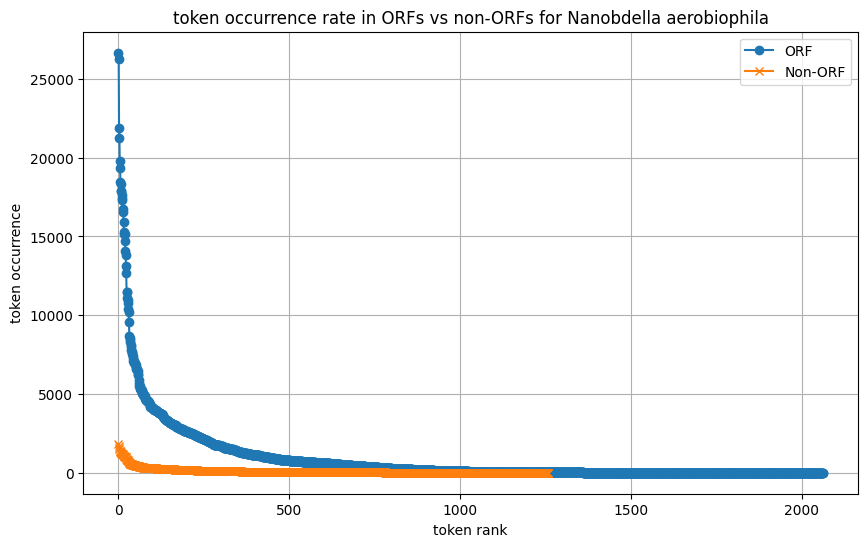

In [109]:
"""
here we processes and analyze orf data for a given organism. It loads the processed orf data, marks the positions of orfs in the genome sequence, aligns k-mers with these positions, 
and then plots the token occurrence rates in the orf and non-orf regions. 
"""


def load_processed_orf_data(org):
    org_filename = org.replace(' ', '_')
    processed_output_path = os.path.join(genome_sequences_dir, f"{org_filename}_orfs", f"{org_filename}_processed.xlsx")
    if os.path.exists(processed_output_path):
        return pd.read_excel(processed_output_path)
    else:
        print(f"processed ORF data file not found: {processed_output_path}")
        return None

def mark_orf_positions(orf_data, genome_length):
    orf_positions = [False] * genome_length
    for idx, row in orf_data.iterrows():
        for i in range(row['Start'], row['End']):
            orf_positions[i] = True
    return orf_positions

def align_orfs_with_kmers(orf_positions, genome_sequence, k):
    orf_kmer_overlap = []
    non_orf_kmer_overlap = []
    for i in range(len(genome_sequence) - k + 1):
        if all(orf_positions[i:i+k]):
            orf_kmer_overlap.append((i, i+k))
        else:
            non_orf_kmer_overlap.append((i, i+k))
    return orf_kmer_overlap, non_orf_kmer_overlap

def plot_token_occurrence_rate_in_orfs(org, tokens, orf_kmer_overlap, non_orf_kmer_overlap, k):
    token_counts_orf = Counter([tuple(tokens[i:i+k]) for start, end in orf_kmer_overlap for i in range(start, end)])
    token_counts_non_orf = Counter([tuple(tokens[i:i+k]) for start, end in non_orf_kmer_overlap for i in range(start, end)])
    
    token_occurrences_orf = sorted(token_counts_orf.values(), reverse=True)
    token_occurrences_non_orf = sorted(token_counts_non_orf.values(), reverse=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(token_occurrences_orf, marker='o', label='ORF')
    plt.plot(token_occurrences_non_orf, marker='x', label='Non-ORF')
    plt.xlabel('token rank')
    plt.ylabel('token occurrence')
    plt.title(f'token occurrence rate in ORFs vs non-ORFs for {org}')
    plt.legend()
    plt.grid(True)
    plt.show()

org = "Nanobdella aerobiophila"
processed_orf_data = load_processed_orf_data(org)
if processed_orf_data is not None:
    print(f"{org} processed ORFs: {processed_orf_data.head()}...")  

    genome_sequence = load_genome_sequence(f"{org.replace(' ', '_')}_processed.txt")
    orf_positions = mark_orf_positions(processed_orf_data, len(genome_sequence))

    k = 3
    orf_kmer_overlap, non_orf_kmer_overlap = align_orfs_with_kmers(orf_positions, genome_sequence, k)
    print(f"total ORF kmer overlaps: {len(orf_kmer_overlap)}")
    print(f"ORF kmer overlap (first 10): {orf_kmer_overlap[:10]}")
    print(f"total non-ORF kmer overlaps: {len(non_orf_kmer_overlap)}")
    print(f"non-ORF kmer overlap (first 10): {non_orf_kmer_overlap[:10]}")

    tokens = [genome_sequence[i:i+k] for i in range(len(genome_sequence) - k + 1)]
    print(f"total tokens: {len(tokens)}")
    print(f"first 10 tokens: {tokens[:10]}")

    plot_token_occurrence_rate_in_orfs(org, tokens, orf_kmer_overlap, non_orf_kmer_overlap, k)
else:
    print(f"processed orf file not found for {org}")

In [110]:
def check_inversion_robustness(org, genome_sequence, vocab, k):
    inverted_genome_sequence = genome_sequence[::-1]
    original_tokens = [genome_sequence[i:i+k] for i in range(len(genome_sequence) - k + 1)]
    inverted_tokens = [inverted_genome_sequence[i:i+k] for i in range(len(inverted_genome_sequence) - k + 1)]
    
    original_compression = calculate_compression(genome_sequence, vocab, k)
    inverted_compression = calculate_compression(inverted_genome_sequence, vocab, k)
    
    print(f"original compression factor for {org}: {original_compression}")
    print(f"inverted compression factor for {org}: {inverted_compression}")

# example for one organism with k=6
check_inversion_robustness(org, genome_sequence, kmer_freqs_all[6], 6)

original compression factor for Nanobdella aerobiophila: 1.0080446009883925
inverted compression factor for Nanobdella aerobiophila: 1.0103877740527243


In [111]:
# here is code to run all of the organisms at once if your computer can handle it and/or if you have a healthy amount patience. Otherwise run each code cell with each org

organisms = [
    "Nanobdella aerobiophila",
    "Candidatus Karelsulcia muelleri",
    "Malassezia restricta",
    "Caenorhabditis elegans",
    "Ostreococcus lucimarinus CCE9901",
    "Theileria orientalis strain Shintoku",
    "Rice yellow mottle virus satellite"
]

for org in organisms:
    print(f"processing organism: {org}")
    
    genome_sequence = load_genome_sequence(f"{org.replace(' ', '_')}_processed.txt")
    
    kmer_freqs_all, genome_sequence = process_organism_kmers(org)
    
    optimal_vocab_size, optimal_compression_factor, compression_factors = heuristic_search_optimal_vocab_size(kmer_freqs_all[6], genome_sequence, 6)
    print(f"optimal vocab size for {org}: {optimal_vocab_size}, compression factor: {optimal_compression_factor}")
    
    chunk_size = 50
    chunks = split_sequence_into_chunks(genome_sequence, chunk_size)
    tokenizer_save_path = os.path.join(tokenizers_dir, f"{org.replace(' ', '_')}_bert_wordpiece_tokenizer.json")
    train_and_save_wordpiece_tokenizer(chunks, optimal_vocab_size, tokenizer_save_path)
    
    tokens = tokenize_sequence(tokenizer, genome_sequence)
    
    #plot_compression_factors(org, compression_factors, list(range(1000, 80000, 500)))
    
    #plot_token_occurrence_rate(org, tokens)
    
    orf_path = find_orfs(org)
    orf_data = load_orf_data(orf_path)
    print(f"{org} ORFs: {orf_data[:5]}...")
    
    check_inversion_robustness(org, genome_sequence, kmer_freqs_all[6], 6)

processing organism: Nanobdella aerobiophila
k-mer frequencies for k=3: defaultdict(<class 'int'>, {'AAT': 34817, 'ATA': 46557, 'TAT': 47254, 'ATT': 35666, 'TTA': 31019, 'TAA': 30209, 'TTT': 36084, 'TTC': 13634, 'TCA': 9088, 'CAT': 10829, 'AAA': 35315, 'TAC': 9576, 'ACT': 7215, 'CTT': 12248, 'TAG': 11958, 'AGT': 7284, 'GTA': 9505, 'GTT': 6845, 'TTG': 10082, 'TGA': 8973, 'GAA': 13475, 'AGG': 5867, 'GGA': 7117, 'GAC': 2324, 'ACA': 7660, 'CAA': 10138, 'CAC': 2072, 'GGT': 4953, 'GTC': 2277, 'TCT': 16642, 'CTA': 11866, 'ATG': 10577, 'TGG': 6654, 'TGT': 7428, 'AAC': 6849, 'ACC': 4963, 'CCT': 5808, 'GAT': 14048, 'ATC': 14133, 'AAG': 12129, 'AGA': 16372, 'GTG': 2023, 'GAG': 4351, 'GGC': 1744, 'GCA': 4581, 'CAG': 4941, 'ACG': 976, 'CGA': 1739, 'AGC': 3860, 'GCT': 3859, 'CTC': 4488, 'TCC': 7065, 'CCA': 6648, 'AA\n': 173, 'A\nA': 142, '\nAT': 206, 'TGC': 4559, 'CTG': 4914, 'CGG': 1297, 'CCG': 1313, 'GCG': 830, 'AG\n': 65, 'G\nA': 62, 'CGT': 972, 'GCC': 1726, 'TCG': 1721, 'GGG': 2143, 'A\nG': 67, 

KeyboardInterrupt: 